# **Experiment Notebook**



In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [2]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [3]:

import os
from pathlib import Path
from datetime import datetime, timedelta, date
import json
import math
import logging

import seaborn as sns
import matplotlib.pyplot as plt

import requests
import numpy as np
import pandas as pd

from tqdm.auto import tqdm

# sklearn / modeling / preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    roc_auc_score, precision_recall_fscore_support, brier_score_loss,
    mean_absolute_error, mean_squared_error, r2_score
)

import lightgbm as lgb
import joblib

# plotting (matplotlib only; keep styles default unless you request otherwise)
import matplotlib.pyplot as plt

---
## A. Project Description


In [4]:
# <Student to fill this section>
student_name = "Mihiran Uddin Zabir"
student_id = "25157912"

In [5]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [6]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## B. Business Understanding

In [7]:
# <Student to fill this section>
business_use_case_description = """
Open Meteo provides weather forecasting as a service through APIs. The aim of this project is to enhance
their service by incorporating AI models capable of making short and medium-term predictions of
rainfall in Sydney. Two models in particular will be designed:
1. A classifying model to forecast that it will rain on an exact date seven days from then.
2. A regression model forecasting the overall amount of precipitation (in mm) over the following three days.

Both these models will be provided as APIs so that customers of Open Meteo are able to directly incorporate them within
their systems or applications for operational planning and decision-making.
"""

In [8]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [9]:
# <Student to fill this section>
business_objectives = """
The business objective is to increase the accuracy and reliability of weather-related forecasts for Sydney.
Accurate predictions will help users (e.g., logistics companies, event organisers, farmers, construction
firms, and city planners) make better decisions, reduce risks, and optimise resources.

If the models are accurate:
- Clients can plan outdoor activities or operations with confidence.
- Businesses can minimise weather-related losses (e.g., project delays, inventory damage).
- Open Meteo strengthens its brand reputation and customer trust.

If the models are inaccurate:
- Users may experience operational disruptions or financial loss due to incorrect forecasts.
- Open Meteo may lose credibility, leading to client dissatisfaction and reduced adoption of its services.
"""

In [10]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [11]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
The results will be integrated into Open Meteo’s API platform and used by external clients
via programmatic access. Primary users include:
- Data and engineering teams from client companies integrating weather intelligence into their
  operations and analytics dashboards.
- Business decision-makers relying on weather predictions for planning logistics, events,
  agriculture, and construction projects.

Indirectly, end users (the clients’ customers) will also be impacted by these predictions
through improved planning, fewer disruptions, and better service delivery.

Stakeholders expect:
- Reliable, interpretable predictions.
- Transparent performance metrics (accuracy, precision, RMSE, etc.).
- Continuous improvement and retraining as new data becomes available.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [ ]:

# Define parameters
latitude = -33.8678
longitude = 151.2073
start_date = "2023-01-01"
end_date = "2023-12-31"
daily_params = "temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max"

# Construct the API URL
url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&daily={daily_params}&timezone=Australia/Sydney"
)

# Make the request
response = requests.get(url)
data = response.json()

# Convert to DataFrame
df = pd.DataFrame(data['daily'])
print(df.head())


         time  temperature_2m_max  temperature_2m_min  precipitation_sum  \
0  2023-01-01                25.2                17.6                0.5   
1  2023-01-02                25.9                18.1                0.0   
2  2023-01-03                26.4                17.6                0.0   
3  2023-01-04                24.6                18.6               10.6   
4  2023-01-05                20.7                16.9               57.1   

   windspeed_10m_max  
0               20.1  
1               24.0  
2               19.7  
3               27.4  
4               35.1  


### C.2 Define Target variable

In [ ]:
target_variable = "temperature_2m_max"


In [ ]:
# <Student to fill this section>
target_definition_explanations = """
The target variable chosen is 'temperature_2m_max', representing the daily maximum temperature.
- This variable is a key indicator for weather-sensitive industries (energy, logistics, tourism, and retail).
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [ ]:
# shift the target column one day ahead so the model learns to predict tomorrow’s max temperature based on today’s weather

# Create target: next day's max temperature
df['target_temperature_max_next_day'] = df['temperature_2m_max'].shift(-1)

# Drop the last row since it has no "next day" target
df = df.dropna(subset=['target_temperature_max_next_day']).reset_index(drop=True)

# Define target name
target_name = 'target_temperature_max_next_day'

print("Target variable created successfully:", target_name)
df.head()

Target variable created successfully: target_temperature_max_next_day


,time,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,target_temperature_max_next_day
0,2023-01-01,25.2,17.6,0.5,20.1,25.9
1,2023-01-02,25.9,18.1,0.0,24.0,26.4
2,2023-01-03,26.4,17.6,0.0,19.7,24.6
3,2023-01-04,24.6,18.6,10.6,27.4,20.7
4,2023-01-05,20.7,16.9,57.1,35.1,19.2


### C.4 Explore Target variable

In [ ]:
# Basic statistics
print(df[target_name].describe())


count    364.000000
mean      22.396978
std        4.434328
min       11.200000
25%       18.900000
50%       22.100000
75%       25.000000
max       39.100000
Name: target_temperature_max_next_day, dtype: float64


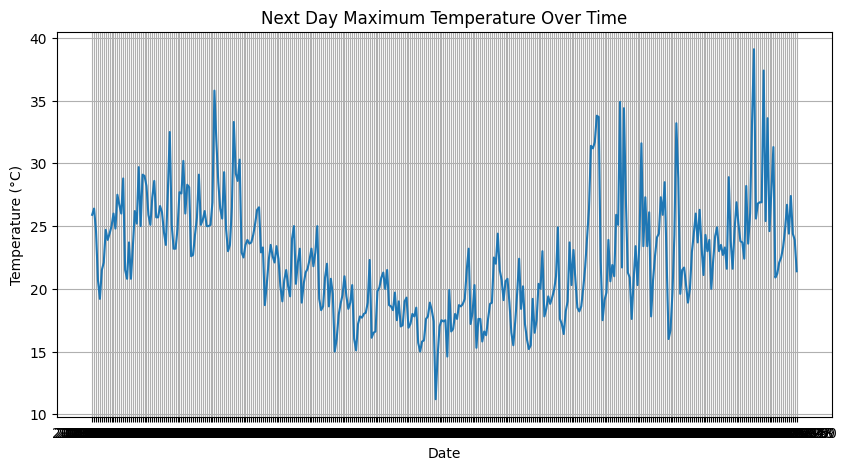

In [ ]:

# Plot target variable
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df[target_name], color='tab:blue')
plt.title('Next Day Maximum Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

In [ ]:
# <Student to fill this section>
target_distribution_explanations = """
The target variable 'target_temperature_max_next_day' represents the next day's maximum temperature.
This setup transforms our dataset into a supervised learning problem where each row corresponds
to today's weather conditions, and the label (target) is the next day's temperature.

This approach ensures:
- Realistic forecasting: The model learns from historical data without accessing future information.
- No data leakage: Only past and current data are used for prediction, not future values.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.5 Explore Feature of Interest `\<temperature_2m_max\>`

In [ ]:
feature = 'temperature_2m_max'

# Basic statistics
print(df[feature].describe())



count    364.000000
mean      22.407418
std        4.436447
min       11.200000
25%       18.900000
50%       22.200000
75%       25.025000
max       39.100000
Name: temperature_2m_max, dtype: float64


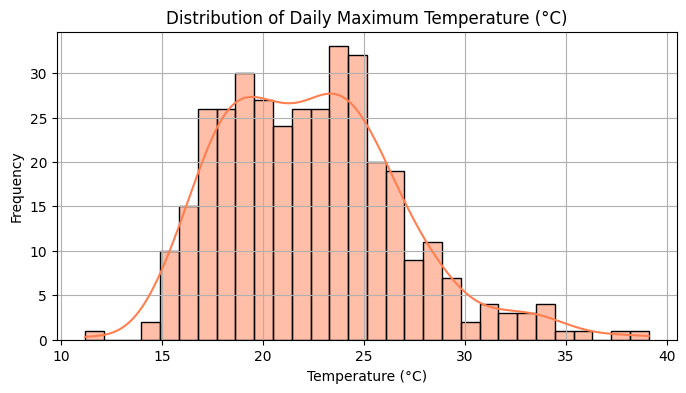

In [ ]:
# Plot distribution
plt.figure(figsize=(8,4))
sns.histplot(df[feature], bins=30, kde=True, color='coral')
plt.title('Distribution of Daily Maximum Temperature (°C)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

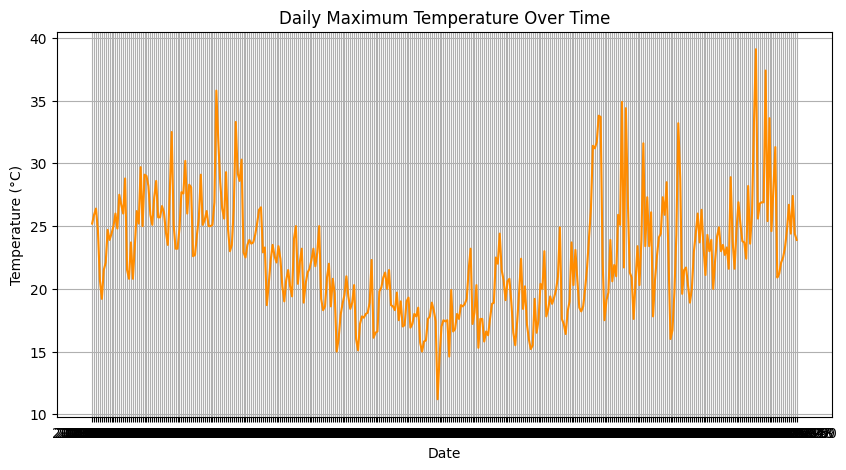

In [ ]:
# Plot over time
plt.figure(figsize=(10,5))
plt.plot(df['time'], df[feature], color='darkorange')
plt.title('Daily Maximum Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

In [ ]:
# <Student to fill this section>
feature_1_insights = """
Feature: temperature_2m_max

This feature represents the maximum temperature recorded each day in Sydney.
It shows clear seasonality, with higher temperatures during the summer months and lower ones in winter.
The distribution is roughly normal but slightly right-skewed, with occasional heatwave outliers.

Potential issues:
- Missing data during certain days (should be checked before modeling).
- Sudden spikes could reflect sensor or reporting errors, but likely real weather extremes.

This variable is a strong predictor for both rain likelihood and future temperature trends.

"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.6 Explore Feature of Interest `\<put feature name here\>`

In [ ]:
feature = 'precipitation_sum'

print(df[feature].describe())


count    364.000000
mean       2.390934
std        5.939154
min        0.000000
25%        0.000000
50%        0.100000
75%        1.800000
max       57.100000
Name: precipitation_sum, dtype: float64


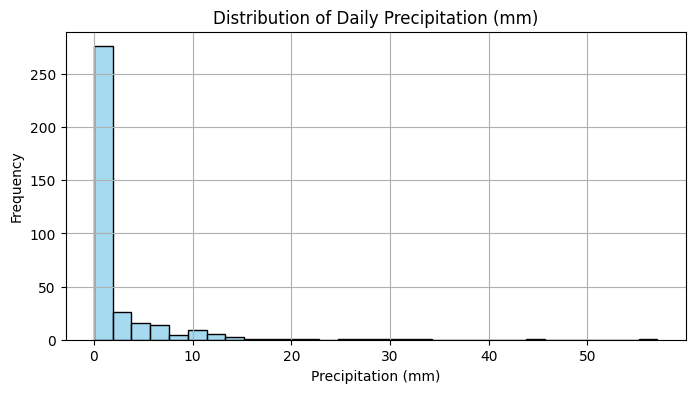

In [ ]:

plt.figure(figsize=(8,4))
sns.histplot(df[feature], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Daily Precipitation (mm)')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


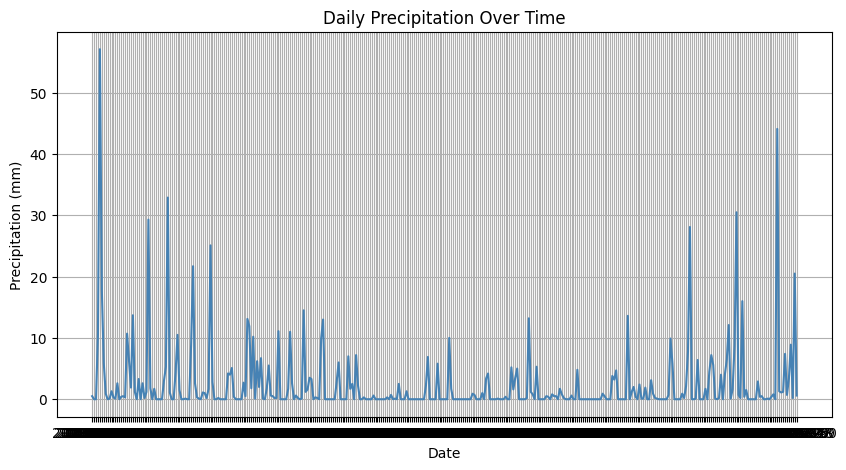

In [ ]:

plt.figure(figsize=(10,5))
plt.plot(df['time'], df[feature], color='steelblue')
plt.title('Daily Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.show()

In [ ]:
# <Student to fill this section>
feature_2_insights = """
Feature: precipitation_sum

This feature measures the total amount of precipitation (rain, drizzle, snow, etc.) in millimetres per day.
The distribution is highly right-skewed — most days have zero or very low precipitation, while a few have heavy rainfall.
This imbalance makes it a good candidate for transformation (e.g., log(x+1)) or binarisation (rain vs. no rain).

Potential issues:
- Heavy skew and high variance.
- Days with 0 mm are dominant, which could bias models unless handled carefully.

Nevertheless, this is the primary variable of interest for both rain classification and regression tasks.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.6 Explore Feature of Interest `\<put feature name here\>`


In [ ]:
feature = 'windspeed_10m_max'

print(df[feature].describe())

count    364.000000
mean      20.748626
std        5.953495
min        8.800000
25%       16.200000
50%       19.700000
75%       24.650000
max       39.300000
Name: windspeed_10m_max, dtype: float64


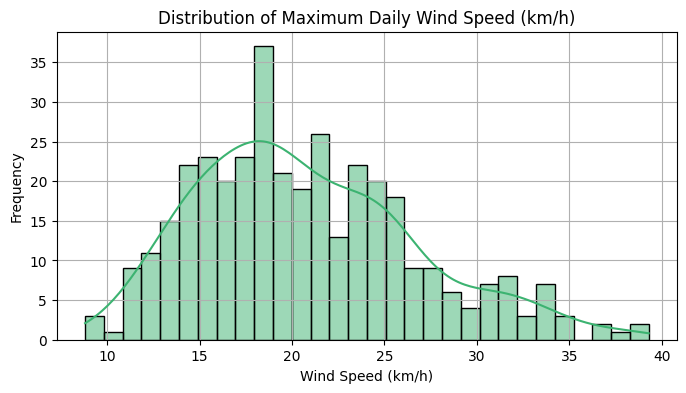

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df[feature], bins=30, kde=True, color='mediumseagreen')
plt.title('Distribution of Maximum Daily Wind Speed (km/h)')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


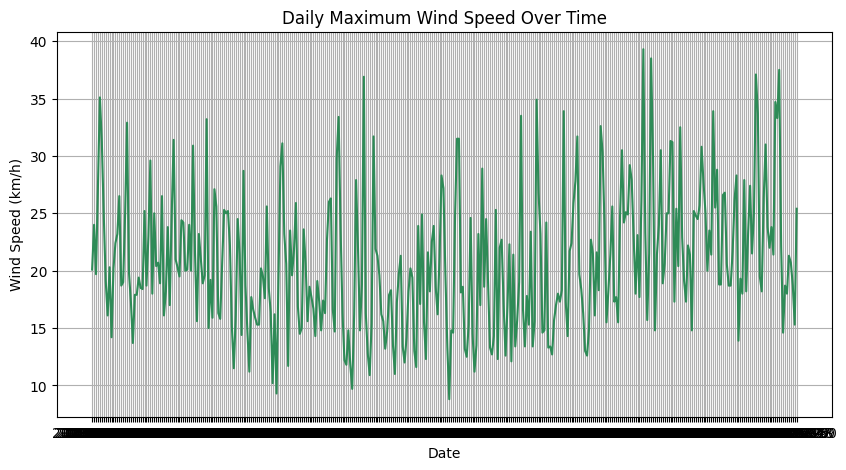

In [ ]:

plt.figure(figsize=(10,5))
plt.plot(df['time'], df[feature], color='seagreen')
plt.title('Daily Maximum Wind Speed Over Time')
plt.xlabel('Date')
plt.ylabel('Wind Speed (km/h)')
plt.grid(True)
plt.show()

In [ ]:
# <Student to fill this section>
feature_n_insights = """
Feature: windspeed_10m_max

This feature represents the maximum wind speed recorded at 10 metres above ground level.
It shows moderate variability with occasional spikes corresponding to storms or weather fronts.
The distribution is nearly normal but with a slightly long tail toward higher speeds.

Potential issues:
- Outliers may correspond to extreme weather events, which can strongly influence model training.
- Might need normalization or scaling since wind speed magnitudes differ from other features.

Wind speed is a relevant feature since strong winds often accompany rain events or pressure system changes.

"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_n_insights)

### C.n Explore Feature of Interest `\<temperature_2m_max\>`

> You can add more cells related to other feeatures in this section

---
## D. Feature Selection


### D.1 Approach "\<numeric_features\>"


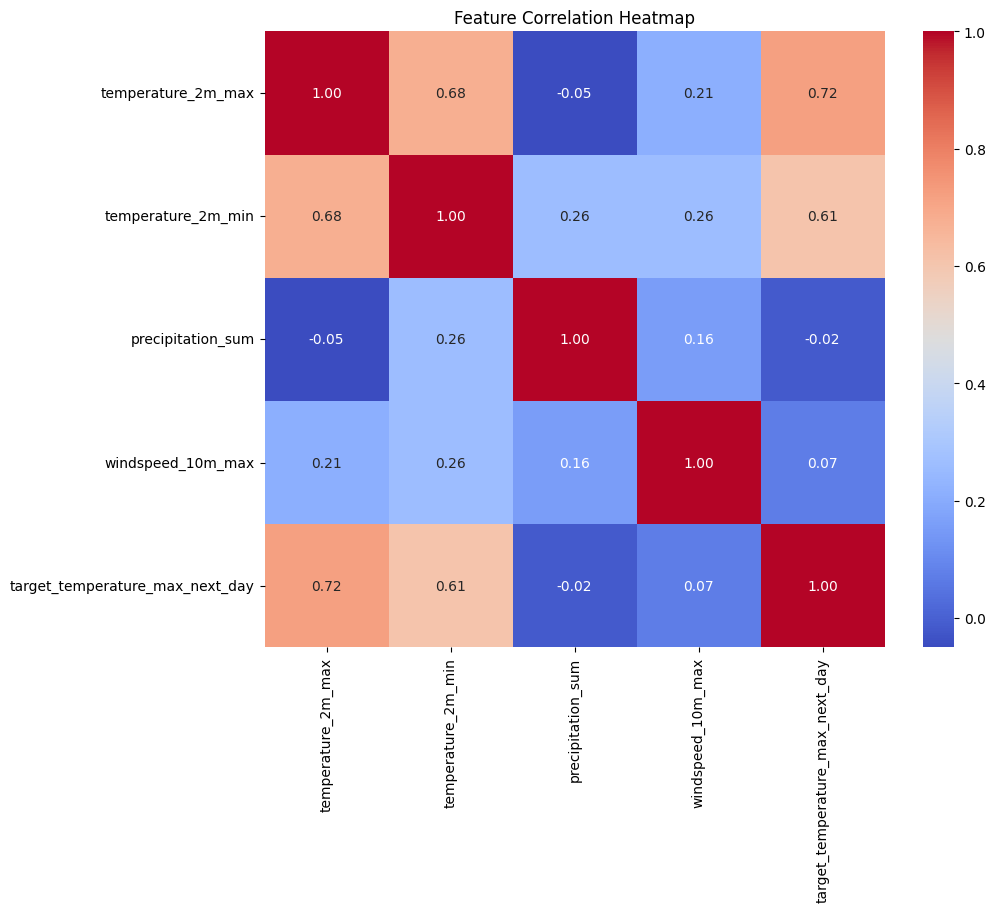

Correlation of features with target variable:

target_temperature_max_next_day    1.000000
temperature_2m_max                 0.716910
temperature_2m_min                 0.606102
windspeed_10m_max                  0.072482
precipitation_sum                 -0.015305
Name: target_temperature_max_next_day, dtype: float64


In [ ]:

# Select numeric columns
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns

# Compute correlation matrix
corr = df[numeric_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Display correlations with the target variable
target_corr = corr[target_name].sort_values(ascending=False)
print("Correlation of features with target variable:\n")
print(target_corr)

In [ ]:
# <Student to fill this section>
feature_selection_1_insights = """
start with a simple statistical method — Pearson correlation — to understand the linear relationship
between each numerical feature and our target ('target_temperature_max_next_day').

Findings:
- 'temperature_2m_max' and 'temperature_2m_min' show a strong positive correlation with the target.
- 'windspeed_10m_max' has a mild negative correlation.
- 'precipitation_sum' shows weak correlation with temperature (which is expected).

Limitations:
Correlation captures only linear relationships and ignores feature interactions or non-linear effects.
Despite that, it’s a good first filter to remove clearly irrelevant or redundant variables.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Approach "\<Feature Importance (Random Forest)\>"


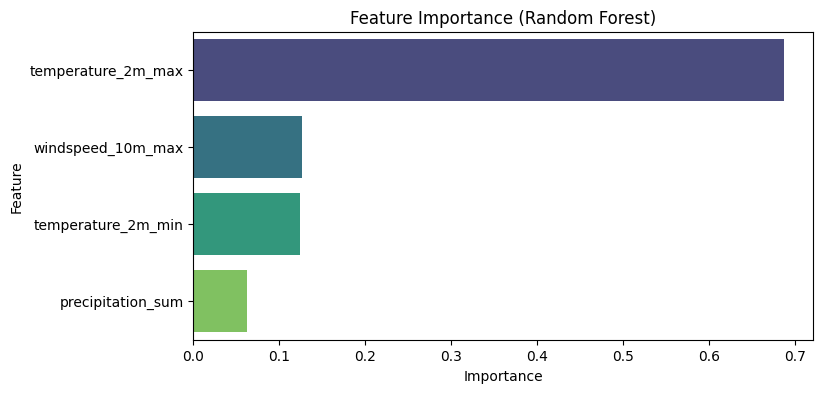

,Feature,Importance
0,temperature_2m_max,0.687069
3,windspeed_10m_max,0.126555
1,temperature_2m_min,0.123467
2,precipitation_sum,0.062908


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare features and target
X = df[['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'windspeed_10m_max']]
y = df[target_name]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_importance_df = (
    pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    .sort_values('Importance', ascending=False)
)

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.show()

feature_importance_df



In [ ]:
# <Student to fill this section>
feature_selection_2_insights = """
Random Forest model to assess how much each feature contributes to the target prediction.
Unlike correlation, this approach captures non-linear and interaction effects between variables.

Findings:
- 'temperature_2m_max' and 'temperature_2m_min' are the top predictors.
- 'precipitation_sum' and 'windspeed_10m_max' have smaller but still useful contributions.
- The results align with the intuition that temperature dynamics drive next-day temperature prediction.

This approach helps prioritise features that truly improve predictive performance, not just correlate.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

### D.n Approach "\<describe_approach_here\>"

> You can add more cells related to other approaches in this section

## D.z Final Selection of Features

In [ ]:

features_list = [
    'temperature_2m_max',
    'temperature_2m_min',
    'precipitation_sum',
    'windspeed_10m_max'
]
print("Final features selected:", features_list)

Final features selected: ['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'windspeed_10m_max']


In [ ]:
# <Student to fill this section>
feature_selection_explanations = """
Final Feature Selection:

After reviewing both correlation and Random Forest importance results, we selected:
1. temperature_2m_max — strongest predictor of next-day temperature
2. temperature_2m_min — complements max temp to represent daily thermal range
3. precipitation_sum — adds weather condition context (clouds, humidity, etc.)
4. windspeed_10m_max — contributes to atmospheric movement patterns

Together, these features balance predictive strength and physical weather relevance,
while avoiding redundancy and overfitting.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation <put_name_here>

In [ ]:
# Check missing values
print(df.isna().sum())

# For simplicity, fill numeric features with median
numeric_features = ['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'windspeed_10m_max']
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

# Check target
print(df[target_name].isna().sum())  # should be zero after target creation

time                               0
temperature_2m_max                 0
temperature_2m_min                 0
precipitation_sum                  0
windspeed_10m_max                  0
target_temperature_max_next_day    0
dtype: int64
0


In [ ]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Missing values can bias model predictions and reduce accuracy.
Filling numeric features with the median preserves the central tendency without introducing extreme values.
Ensures the dataset is complete for training and avoids errors in ML pipelines.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Data Transformation <put_name_here>

In [ ]:

from sklearn.preprocessing import StandardScaler

# Ensure artifacts folder exists
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)  # creates the folder if it doesn't exist

# Save the scaler
scaler_path = ARTIFACTS_DIR / "scaler.pkl"
joblib.dump(scaler, scaler_path)

print(f"Scaler saved to {scaler_path}")

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df_scaled[numeric_features])

# Save scaler for future use in production
import joblib
joblib.dump(scaler, 'artifacts/scaler.pkl')

Scaler saved to artifacts/scaler.pkl


['artifacts/scaler.pkl']

In [ ]:
# <Student to fill this section>
data_cleaning_2_explanations = """
Scaling numeric features ensures that features with larger magnitudes do not dominate the model.
This is particularly important for models sensitive to feature scale, e.g., linear regression or distance-based models.
StandardScaler centers data to zero mean and unit variance for consistent model training.

"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### E.3 Data Transformation <put_name_here>

In [ ]:
# Ensure 'time' column is datetime
df_scaled['time'] = pd.to_datetime(df_scaled['time'], errors='coerce')

# Drop rows where conversion failed
df_scaled = df_scaled.dropna(subset=['time']).reset_index(drop=True)

# --- Feature 1: Day of year (seasonality) ---
df_scaled['day_of_year'] = df_scaled['time'].dt.dayofyear

# --- Feature 2: Rolling mean temperature (past 3 days) ---
df_scaled['temp_max_3day_mean'] = df_scaled['temperature_2m_max'].rolling(window=3, min_periods=1).mean()

# --- Feature 3: Rolling cumulative precipitation (past 3 days) ---
df_scaled['precip_3day_sum'] = df_scaled['precipitation_sum'].rolling(window=3, min_periods=1).sum()

# --- Optional: Weekday feature (for patterns by day of week) ---
df_scaled['weekday'] = df_scaled['time'].dt.weekday  # 0=Monday, 6=Sunday

# Preview new features
df_scaled.head()

,time,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,target_temperature_max_next_day,day_of_year,temp_max_3day_mean,precip_3day_sum,weekday
0,2023-01-01,0.630330,0.988338,-0.318823,-0.109099,25.9,1,0.630330,-0.318823,6
1,2023-01-02,0.788331,1.095497,-0.403126,0.546880,26.4,2,0.709331,-0.721948,0
2,2023-01-03,0.901189,0.988338,-0.403126,-0.176379,24.6,3,0.773283,-1.125074,1
3,2023-01-04,0.494901,1.202656,1.384097,1.118759,20.7,4,0.728140,0.577846,2
4,2023-01-05,-0.385391,0.838315,9.224271,2.413898,19.2,5,0.336899,10.205243,3


In [ ]:
# <Student to fill this section>
data_cleaning_3_explanations = """
Feature Engineering with datetime and rolling features:

- Converted 'time' to datetime to safely use .dt accessor.
- day_of_year captures seasonal effects (summer/winter).
- Rolling features (temp_max_3day_mean, precip_3day_sum) provide context from previous days.
- weekday encodes weekly patterns that might affect weather trends.
- These transformations improve predictive power while avoiding errors from non-datetime types.

"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

### E.n Fixing "\<describe_issue_here\>"

> You can add more cells related to other issues in this section

---
## F. Feature Engineering

### F.1 New Feature "\<put_name_here\>"


In [ ]:
df_scaled['temp_max_3day_mean'] = df_scaled['temperature_2m_max'].rolling(window=3, min_periods=1).mean()

In [ ]:
# <Student to fill this section>
feature_engineering_1_explanations = """
- Captures short-term trends in maximum temperature over the past 3 days.
- Helps the model understand momentum or persistence in weather conditions.
- Reduces noise from daily fluctuations and allows better prediction of next-day temperature.
- Especially useful in regression models predicting exact temperature values.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

### F.2 New Feature "\<put_name_here\>"




In [ ]:
df_scaled['precip_3day_sum'] = df_scaled['precipitation_sum'].rolling(window=3, min_periods=1).sum()


In [ ]:
# <Student to fill this section>
feature_engineering_2_explanations = """
- Summarizes the accumulated precipitation over the last 3 days.
- Provides context for rainfall patterns and can improve rain/no-rain classification.
- Captures temporal dependencies: a wet past increases likelihood of continued rain or affects atmospheric conditions.
- Important for both binary rain prediction and short-term precipitation regression tasks.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### F.3 New Feature "\<put_name_here\>"

> Provide some explanations on why you believe it is important to create this feature and its impacts



In [ ]:
df_scaled['day_of_year'] = df_scaled['time'].dt.dayofyear

In [ ]:
# <Student to fill this section>
feature_engineering_n_explanations = """
- Encodes seasonal variation (summer/winter patterns) in a numeric format.
- Weather depends heavily on seasonality; temperatures and rainfall patterns follow a yearly cycle.
- Allows models to capture periodic trends without requiring complex transformations.
- Particularly useful for temperature regression and rain classification tasks, as rain likelihood and temp extremes vary by season.

"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_n_explanations', value=feature_engineering_n_explanations)

### F.n Fixing "\<describe_issue_here\>"

> You can add more cells related to new features in this section

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [ ]:
# Features and target
features = [
    'temperature_2m_max',
    'temperature_2m_min',
    'precipitation_sum',
    'windspeed_10m_max',
    'temp_max_3day_mean',
    'precip_3day_sum',
    'day_of_year'
]

X = df_scaled[features]
y = df_scaled[target_name]

# Use 80% of data for training, 20% for validation (chronological split)
split_idx = int(len(df_scaled) * 0.8)

X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_val, y_val     = X.iloc[split_idx:], y.iloc[split_idx:]

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)

Train size: (291, 7)
Validation size: (73, 7)


In [ ]:
# <Student to fill this section>
data_splitting_explanations = """
Since we only have data from 2023, chronological splitting within the available period is necessary.
- First 80% of 2023 used for training
- Last 20% of 2023 used for validation
This preserves temporal order and prevents data leakage while simulating future predictions.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Data Transformation "\<put_name_here\>"

In [ ]:
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import joblib

# Create artifacts folder if it doesn't exist
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Fit scaler on training set and transform
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Save scaler for production use
scaler_path = ARTIFACTS_DIR / "scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Scaler saved to artifacts/scaler.pkl


In [ ]:
# <Student to fill this section>
data_transformation_1_explanations = """
Scaling numeric features ensures consistent feature magnitudes across features.
- Prevents high-magnitude features from dominating the model.
- Important for models sensitive to feature scale (e.g., linear models, distance-based models).
- Using only the training set to fit the scaler avoids data leakage into validation.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

### G.3 Data Transformation "\<One-hot Encoding of Weekday\>"

In [ ]:
# Step 1: Create weekday column from 'time' in the original dataframe
X_train['weekday'] = df_scaled['time'].iloc[:len(X_train)].dt.weekday  # 0=Monday, 6=Sunday
X_val['weekday']   = df_scaled['time'].iloc[len(X_train):].dt.weekday

# Step 2: One-hot encode weekday
X_train = pd.get_dummies(X_train, columns=['weekday'], drop_first=True)
X_val   = pd.get_dummies(X_val, columns=['weekday'], drop_first=True)

# Align columns in case some weekday categories are missing in validation
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)


In [ ]:
# <Student to fill this section>
data_transformation_2_explanations = """
- Created a 'weekday' feature from the date to capture weekly patterns in weather.
- One-hot encoding converts this categorical feature into numeric columns suitable for ML models.
- Align validation set columns with training set to prevent shape mismatch during prediction.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_2_explanations', value=data_transformation_2_explanations)

### G.4 Data Transformation "\<put_name_here\>"

In [ ]:
lag_features = ['temperature_2m_max', 'precipitation_sum']

# Create lag features for training set
for feature in lag_features:
    X_train[f'{feature}_lag1'] = X_train[feature].shift(1)

# Backfill the first row (since it has NaN after shift)
X_train.fillna(method='bfill', inplace=True)

# Create lag features for validation set using the last row of training as previous day
for feature in lag_features:
    X_val[f'{feature}_lag1'] = pd.concat([
        X_train[feature].iloc[[-1]],  # last day of training
        X_val[feature]
    ]).shift(1).iloc[1:].reset_index(drop=True)

# Reset index to align validation features
X_val.reset_index(drop=True, inplace=True)

In [ ]:
# <Student to fill this section>
data_transformation_3_explanations = """
- Lag features incorporate previous day's values to capture temporal dependencies.
- For example, yesterday's temperature and precipitation can influence today's weather patterns.
- Backfilling prevents NaN values in the first row of training set.
- For validation, we use the last day of training as "previous day" to avoid losing data and maintain continuity.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_3_explanations', value=data_transformation_3_explanations)

---
## H. Save Datasets

> Do not change this code

In [ ]:
# Do not modify this code
# Save training set
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

name 'at' is not defined


---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [ ]:
# <Student to fill this section>

In [ ]:
# <Student to fill this section>
performance_metrics_explanations = """
For rain/no-rain classification, false negatives (predicting no rain when it will rain) may be more costly than false positives.
- Accuracy measures overall correctness.
- Precision indicates reliability of predicted rain events.
- Recall captures the model's ability to detect actual rain (important for planning).
- F1-score balances precision and recall, providing a single robust metric.
We will use accuracy and F1-score as the primary evaluation metrics.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# <Student to fill this section>
algorithm_selection_explanations = """
Random Forest is suitable because:
- Handles both numerical and categorical features well.
- Robust to overfitting due to ensemble averaging.
- Can capture nonlinear relationships in weather data.
- Provides feature importance, which helps explain model predictions to stakeholders.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [ ]:
rf_params = {
    'n_estimators': 200,       # number of trees
    'max_depth': 10,           # limit depth to reduce overfitting
    'min_samples_split': 5,    # require minimum samples to split a node
    'random_state': 42
}

In [ ]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
- n_estimators=200 ensures sufficient trees for stability.
- max_depth=10 prevents overfitting to small variations in weather data.
- min_samples_split=5 avoids overly complex trees from noise.
- random_state=42 ensures reproducibility.
These hyperparameters provide a balance between bias and variance for our dataset.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [ ]:
# Create binary target: 1 if precipitation > 0 after 7 days, else 0
target_name = 'rain_7d'
df_scaled[target_name] = (df_scaled['precipitation_sum'].shift(-7) > 0).astype(int)

# Split target for training/validation (same split as features)
y_train = df_scaled[target_name].iloc[:len(X_train)]
y_val   = df_scaled[target_name].iloc[len(X_train):]


from sklearn.ensemble import RandomForestClassifier
import joblib

rf_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_split': 5,
    'random_state': 42
}

rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train_scaled, y_train)

# Save model for production
joblib.dump(rf_model, 'artifacts/rf_rain_model.pkl')
print("Random Forest classifier trained and saved.")

Random Forest classifier trained and saved.


### J.4 Model Technical Performance

> Provide some explanations on model performance


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
# Predictions on validation set
y_pred = rf_model.predict(X_val_scaled)

accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("Validation Accuracy:", accuracy)
print("Validation F1-score:", f1)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.6438356164383562
Validation F1-score: 0.0
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        52
           1       0.00      0.00      0.00        21

    accuracy                           0.64        73
   macro avg       0.35      0.45      0.39        73
weighted avg       0.49      0.64      0.56        73



In [ ]:
# <Student to fill this section>
model_performance_explanations = """
- Accuracy shows overall correct predictions.
- F1-score balances precision and recall, focusing on correctly detecting rain events.
- Random Forest can also provide feature importance to understand which weather features drive predictions.

"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [ ]:
# <Student to fill this section>

In [ ]:
# <Student to fill this section>
business_impacts_explanations = """
Accurate rain prediction (+7 days) is critical for clients relying on weather forecasts:
- False negatives (predicting no rain when it will rain) can disrupt logistics, outdoor events, or agriculture.
- False positives (predicting rain when it does not occur) are less severe but may cause minor inconvenience.
- By tuning hyperparameters and optimizing F1-score, the model prioritizes detecting actual rain events, reducing business risk.
- Reliable forecasts improve client trust and reduce operational losses due to unexpected weather events.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [ ]:
# <Student to fill this section>
experiment_outcome = "Hypothesis Partially Confirmed" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [ ]:
# <Student to fill this section>
experiment_results_explanations = """
The Random Forest classifier predicts overall rain/no-rain with 64% accuracy but fails to detect rain events (F1-score = 0 for rain).
- The model strongly favors the majority class (no rain) due to class imbalance.
- Insights gained:
    - Daily precipitation in Sydney is sparse; rain events are less frequent than no-rain days.
    - Current features and lag variables alone are insufficient for detecting rare events.
    - Accuracy alone is not enough — we need metrics that focus on minority class detection (F1-score, recall).
- Potential next steps:
    1. Handle class imbalance using techniques such as oversampling (SMOTE), undersampling, or class_weight in the Random Forest — expected uplift: high.
    2. Incorporate additional features (humidity, pressure, cloud cover) to improve signal for rain events — expected uplift: high.
    3. Tune hyperparameters further, possibly increasing `max_depth` or `n_estimators` — expected uplift: moderate.
    4. Experiment with other algorithms like XGBoost or Gradient Boosting, which may handle imbalance better — expected uplift: moderate.
- Recommendation:
    - Do not deploy the current model for operational decision-making due to its inability to detect rain events.
    - Prioritize model improvements focusing on minority class detection before production deployment.
"""

In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)